# Assignment 1
Emma McCready\
sba23001

---

### Analysis of Ireland's Transport Data




^ implement a project overview/plan like how they do in codecademy projects??

## Scoping

The below four sections are to help guide the EDA during this project and also to structure this codebook as it may get quite long. The first section defines the high-level objectives and set the intentions for the overall project. The next section is the data. Thirdly, the analysis will have to be thought through, which include the methods and questions that are aligned with the project goals. Lastly, evaluation will help us build conclusions and findings from our analysis.

### Project Goals

An aspect of Ireland's Transport data will be analysed and compared to other transport systems in other countries. The focus will be on train systems. Some questions that are posed:

- 

### Data

Sources:
* **Primary dataset**: Iarnród Éireann, code TCA01, available here: <a href="https://data.gov.ie/dataset/tca01-passenger-journeys-by-rail-thousand">link</a>
* **Supplementary dataset 1:** Iarnród Éireann, code TOA21, available here: <a href="https://data.gov.ie/dataset/toa21-rail-infrastructure">link</a>
* **Supplementary dataset 2:** StatBank Denmark, code BANE25, available here: <a href="https://www.statbank.dk/statbank5a/selectvarval/saveselections.asp">link</a>

Data will be cleaned and prepared prior to analysis.

### Analysis

In this section, descriptive statistics and data visualization techniques will be employed to understand the data better. 
The datasets were not viewed before the initiation of this project and may be quite large.

### Evaluation

Lastly, it's a good idea to revisit the goals and check if the output of the analysis corresponds to the questions first set to be answered (in the goals section). This section will also reflect on what has been learned through the process, and if any of the questions were unable to be answered. This could also include limitations or if any of the analysis could have been done using different methodologies.


In [1]:
# Dependencies.. put any packages I install here:
#!pip install pandas==2.1.2
#!pip install ydata_profiling --user

In [2]:
# review this at end to ensure there's no unnecessary packages loaded

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
from scipy.stats import norm
from scipy.stats import poisson, binom, norm
from scipy.stats import shapiro

# ML libraries
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict, 
                                     StratifiedKFold, learning_curve, train_test_split)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.tools.eval_measures import mse, rmse
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

<summary style="color:blue;">

# 1. Data Inspection of the Primary Dataset

This dataset was obtained from the CSO, and pertains to rail transport activity within the Republic of Ireland and rail transport activity where a journey begins or ends in the Republic of Ireland.
    
First, I need to load in the data, and then take a quick look at the data to get a sense of what I'm dealing with. I'm initially interested in what unique columns there are, the data types of the columns,

In [3]:
df1 = pd.read_csv("TCA01.csv")
#df1.head(10)
df1.tail()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02617V03175,Type of Journey,UNIT,VALUE
205,TCA01,Passenger Journeys by Rail (Thousand),2022,2022,-,All journeys,Number,35845.0
206,TCA01,Passenger Journeys by Rail (Thousand),2022,2022,01,Mainline and other services,Number,10338.0
207,TCA01,Passenger Journeys by Rail (Thousand),2022,2022,02,Dublin suburban services,Number,8740.0
208,TCA01,Passenger Journeys by Rail (Thousand),2022,2022,03,DART,Number,15930.0
209,TCA01,Passenger Journeys by Rail (Thousand),2022,2022,04,International journeys,Number,836.0


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC        210 non-null    object 
 1   STATISTIC Label  210 non-null    object 
 2   TLIST(A1)        210 non-null    int64  
 3   Year             210 non-null    int64  
 4   C02617V03175     210 non-null    object 
 5   Type of Journey  210 non-null    object 
 6   UNIT             210 non-null    object 
 7   VALUE            165 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 13.3+ KB


In [5]:
#df1.describe()
df1.describe(include=object)

,STATISTIC,STATISTIC Label,C02617V03175,Type of Journey,UNIT
count,210,210,210,210,210
unique,1,1,5,5,1
top,TCA01,Passenger Journeys by Rail (Thousand),-,All journeys,Number
freq,210,210,42,42,210


In [6]:
#checking amount of missing data..
df1.isnull().sum()

STATISTIC           0
STATISTIC Label     0
TLIST(A1)           0
Year                0
C02617V03175        0
Type of Journey     0
UNIT                0
VALUE              45
dtype: int64

In [7]:
duplicates = df1.duplicated()
print(duplicates.value_counts())

False    210
dtype: int64


In [8]:
df1["TLIST(A1)"].equals(df1["Year"])

True

### Observations on the above:

**From calling `.head()`:**
* STATISTIC and STATISTIC Label columns redundant. UNIT also irrelevant. VALUE column refers to the number of passender journeys by rail in thousands.
* Not sure what TLIST(A1) is, possibly an error from when the data was downloaded from the CSO website? Will have to check if the columns are equal and if so drop one of the columns.
* Similarly, not sure what C02617V03175 refers to - will have to check values. From looking at .head(10), it might just be an index key for the Type of Journey values?


**From calling `.info()`:**
* Dataset contains 210 observations
* The statistical information extracted (ie. the mean, std, etc.) isn't reliable at this early stage, as there's a total variable also ('All journeys')


**From calling `.describe()`:**
* For the numerical features:
    * Year column: ranges from 1981 to 2022.
    * Missing values in VALUE column.. will need to investigate and decide what to do with them.
* For the categorical features:
    * "STATISTIC Label" and "UNIT" only have one unique value each ("Passenger Journeys by Rail (Thousand)" and "number" respectively)
    * "C02617V03175" and "Type of Journey" both have 5 unique values - this reinforces my assumption that C02617V03175 is a sort of key for the latter feature. This will need to be confirmed.


**From calling `.isnull().sum()`:**
* 45 missing values in the VALUE field. Will need to investigate and figure out why these are missing. 45 is significant as dataset contains only 210 observations - this means 21.4% of the observations contain missing values.


**From calling `duplicates.value_counts()`:**
* There are no duplicated observations.

**From calling `df1["TLIST(A1)"].equals(df1["Year"])`:**
* Output is true, implying these columns are the exact same, and one of these columns can be dropped.



One of the labels under the "Type of Journey" feature is "International journeys". Noting that Ireland is an island with no linking tunnels, I'd like to get a closer look at this. In doing this, I'll confirm that "C02617V03175" is just an index key (and can therefore be dropped to tidy the dataset), and filter both "Type of Journey" and "C02617V03175" for the relevant variable:

In [9]:
int_journeys1 = df1[df1["Type of Journey"] == "International journeys"]
int_journeys2 = df1[df1["C02617V03175"] == "04"]
#int_journeys1.info()
#int_journeys2.info()
int_journeys1.equals(int_journeys2)

True

In [10]:
int_journeys1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 4 to 209
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC        42 non-null     object 
 1   STATISTIC Label  42 non-null     object 
 2   TLIST(A1)        42 non-null     int64  
 3   Year             42 non-null     int64  
 4   C02617V03175     42 non-null     object 
 5   Type of Journey  42 non-null     object 
 6   UNIT             42 non-null     object 
 7   VALUE            21 non-null     float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.0+ KB


This confirms that "C02617V03175" is an index key, and can therefore be dropped. 
From calling .info(), I can see that there are 21 non-null values, and therefore some international journeys taking place. From my own knowledge of the Irish Rail system, I can assume that this is the Dublin -> Belfast route, but there's no information in the current dataset which can confirm this.

In [11]:
int_journeys1.isnull().sum()

STATISTIC           0
STATISTIC Label     0
TLIST(A1)           0
Year                0
C02617V03175        0
Type of Journey     0
UNIT                0
VALUE              21
dtype: int64

<summary style="color:blue;">

# 2. Preparing the Primary Dataset


<summary style="color:blue;">

###### 2.1 Dropping "Statistic Label", "TLIST(A1)", "C02617V03175" and "UNIT" columns 
    
</summary>


I was planning on removing the "Statistic Label" as I felt it's providing no purpose in the analysis. However, I redecided to keep it as it contains important information which may be forgotten in the future (that the VALUEs for each observation are in thousands)
    
    
I'm also removing the "UNIT" column, as I would rather include this in the "VALUE" column (by multiplying the values by a thousand)

As noted above, "TLIST(A1)" is a duplication of the "Year" column, and so should be dropped. Further, "C02617V03175" can be dropped as it is just an index key, and I'd rather work with the strings in the "Type of Journey" column which are a full description of the type of journey. 
    
    
Doing this should make the dataframe less clunky and easier to explore

However, I will keep the "Statistic" column as this could be a useful reference when I merge data to this dataset in the future.

In [12]:
df1 = df1.drop(columns = ['TLIST(A1)', 'C02617V03175', 'UNIT'])
#df1.head()

<summary style="color:blue;">

###### 2.2 Renaming the column headings
    
</summary>
    
This is just to make it easier to write code, and also to make headings reflect the data their respective column contains more accurately. I also want to make them all lowercase so it's more convenient to type. I won't touch the STATISTIC column heading as it's unlikely I'll be utilising it.

In [13]:
df1.head()

,STATISTIC,STATISTIC Label,Year,Type of Journey,VALUE
0,TCA01,Passenger Journeys by Rail (Thousand),1981,All journeys,15374.0
1,TCA01,Passenger Journeys by Rail (Thousand),1981,Mainline and other services,7379.0
2,TCA01,Passenger Journeys by Rail (Thousand),1981,Dublin suburban services,7995.0
3,TCA01,Passenger Journeys by Rail (Thousand),1981,DART,NaN
4,TCA01,Passenger Journeys by Rail (Thousand),1981,International journeys,NaN


In [14]:
df1 = df1.rename(columns = {'Year':'year', 
                            'Type of Journey':'journey_type',
                            'VALUE':'passenger_count'})
df1.columns

Index(['STATISTIC', 'STATISTIC Label', 'year', 'journey_type',
       'passenger_count'],
      dtype='object')

<summary style="color:blue;">

###### 2.3 Missing Values
    
</summary>

First, I want to look at the missing values, so I'll move them into a new dataset. I'm particularly interested in what values are actually missing. Also interested in what year the missing data is, so I can decide if limiting the analysis to a particular year range is better. As noted from calling .info() on the dataset earlier, only "passenger_count" contains missing values, so I can streamline the code a little:
    

In [15]:
missing_count = df1['passenger_count'].isnull().sum()

print('There are', missing_count, 'missing values in the total_migration column. The total percentage of missing values is', round((missing_count/len(df1) * 100), 2), '%')

There are 45 missing values in the total_migration column. The total percentage of missing values is 21.43 %


In [16]:
missing = pd.isnull(df1['passenger_count'])
missing_data = df1[missing]
#missing_data

From viewing the dataframe containing observations with missing values, I note that there's data missing for international journeys until 2001 inclusive, and for the DART to 2004 inclusive. This data is missing not at random (MNAR), as it's likely this information wasn't collected prior to these years and the passenger numbers were instead included in another journey type. I'll keep this data in there for now and reconsider what to do when I'm doing further analysis.

## Summary of the data tidying:

I dropped the irrelevant columns but kept "Statistic label" to remember that `passenger_count` is in thousands

This dataset contains missing values, which are Missing Not at Random (MNAR).



<summary style="color:blue;">
    
# 3. Visualising the Primary Dataset

</summary>

##### Figure key:  
3.1 Total Passenger Count Over Time

###### My approach when putting together these visualisations:
The ultimate goal was to visually explore the primary dataset.
A stepwise approach was taken with the programming, as the data was first filtered using a boolean mask approach, and then plotted. In the interest of making the code as tidy as possible, subplots were used.

In terms of visualisations, Tufte’s Principles were followed. 
* Plots were all labelled with axes titles and plot titles
* redundant ink (e.g. gridlines) and non-data ink removed, to ensure data isn't drowned out.
* another example of inimising redundant ink was the decision not to multiply the passenger_count column by a thousand to reflect the true value.
* data-ink ratio maximised, to ensure readers interpret the message that the data is conveying.
* default colours used, as this is in line with what readers are most accustomed to.
* for plots with multiple variables, I felt the detault palette wasn't sutiable as the red and orange are quite similar. Instead, I used the "Set1" palette which is built into Seaborn

<summary style="color:blue;">
    
###### 3.1 Total Passenger Count Over Time

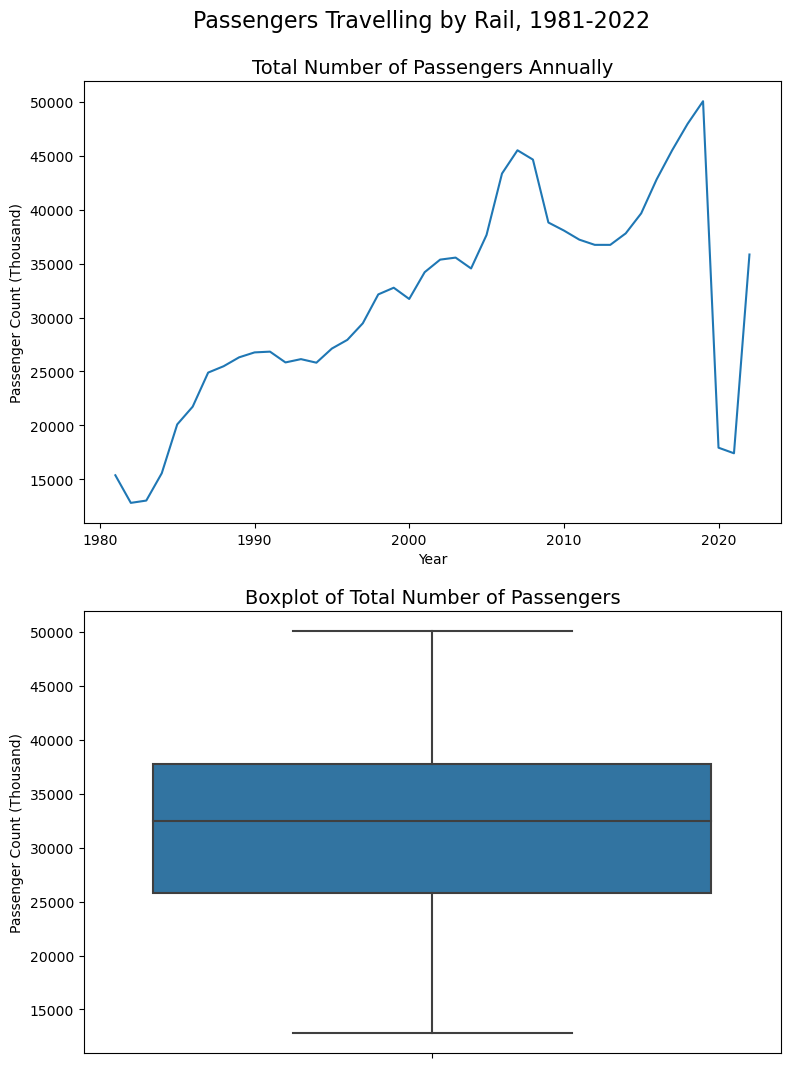

In [17]:
total_passenger_count = df1[df1["journey_type"] == "All journeys"]

plt.figure(figsize=(9, 12))
plt.suptitle('Passengers Travelling by Rail, 1981-2022', fontsize=16)

plt.subplot(2, 1, 1)
sns.lineplot(x='year', y='passenger_count', data=total_passenger_count)
plt.xlabel('Year')
plt.ylabel('Passenger Count (Thousand)')
plt.title('Total Number of Passengers Annually', fontsize=14)

plt.subplot(2, 1, 2)
sns.boxplot(y='passenger_count', data=total_passenger_count)
plt.ylabel('Passenger Count (Thousand)')
plt.title('Boxplot of Total Number of Passengers', fontsize=14)

plt.subplots_adjust(top=0.92, hspace=0.2)
plt.show()

In [18]:
total_passenger_count['passenger_count'].describe()

count       42.000000
mean     31458.571429
std       9802.232394
min      12813.000000
25%      25819.000000
50%      32455.500000
75%      37766.750000
max      50060.000000
Name: passenger_count, dtype: float64

###### Reflections on the above:

* The _annual passenger count_ steadily increased until approx 2009-2013 when it dropped slightly, and then again in 2020 when it dropped dramatically. It can be assumed that the former was a result of the economic crisis, and that the latter decrease was a result of COVID-19. The 2022 figure shows it's on the upward trend again, but still not at pre-pandemic levels, likely due to an increasing amount of remote and hybrid workers.

* _Statistical information:_ The mean annual passenger count is 31458.57, and the median is 32455.50. The difference means the data is very slightly skewed to the left, as can be observed in the boxplot above. This is surprising as, with expansion of train lines with more investment over the years, you'd expect it to be much more significantly skewed to the left as passenger numbers increase.

<summary style="color:blue;">
    
###### 3.2 Total Passenger Across Journey Types

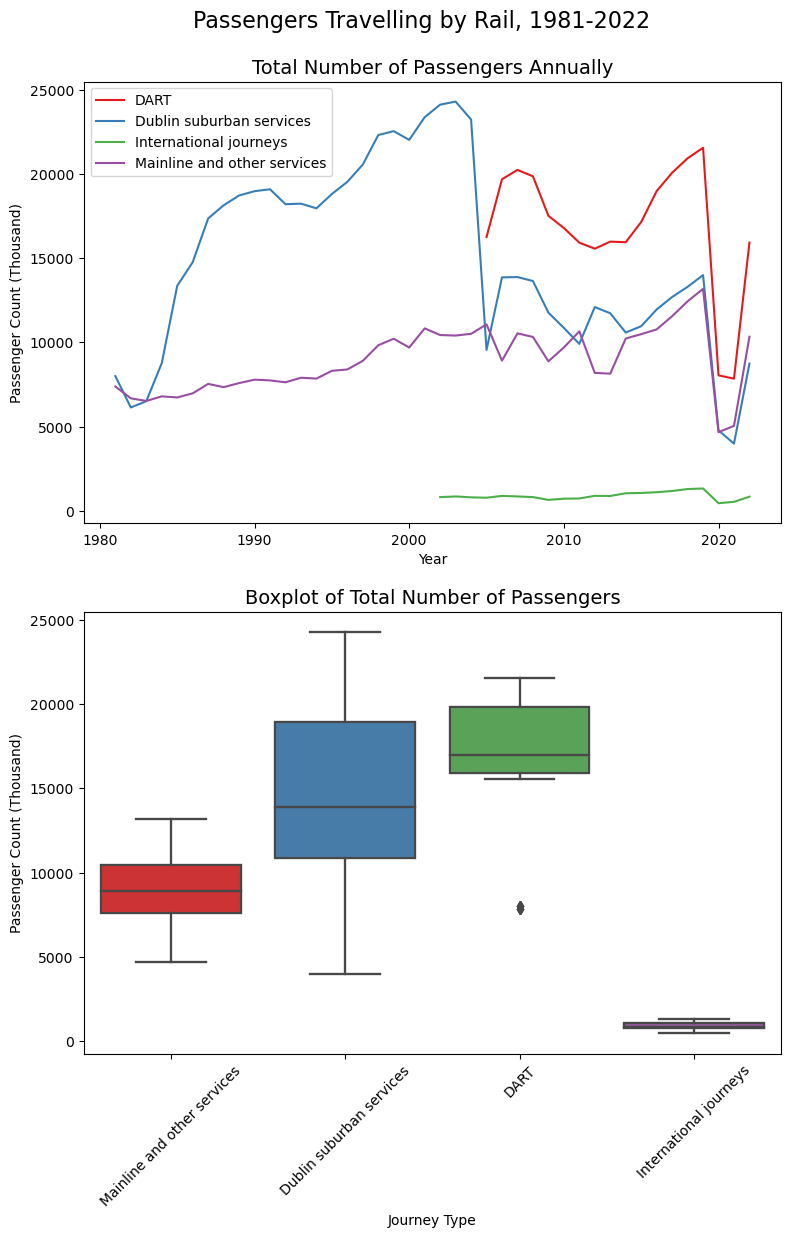

In [19]:
total_passenger_journey_type = df1[df1["journey_type"] != "All journeys"]

df_pivot = total_passenger_journey_type.pivot(index='year', columns='journey_type', values='passenger_count')

custom_palette = sns.color_palette("Set1", n_colors=len(df_pivot.columns)) # more distinct colour palette than the default

plt.figure(figsize=(9, 12))
plt.suptitle('Passengers Travelling by Rail, 1981-2022', fontsize=16)

plt.subplot(2, 1, 1)
for i, journey_type in enumerate(df_pivot.columns):
    sns.lineplot(x=df_pivot.index, y=df_pivot[journey_type], label=journey_type, color=custom_palette[i])
plt.xlabel('Year')
plt.ylabel('Passenger Count (Thousand)')
plt.title('Total Number of Passengers Annually', fontsize=14)

plt.subplot(2, 1, 2)
for i, journey_type in enumerate(df_pivot.columns):
    sns.boxplot(data=total_passenger_journey_type, x='journey_type', y='passenger_count', palette=custom_palette)
plt.xlabel('Journey Type')
plt.xticks(rotation=45)
plt.ylabel('Passenger Count (Thousand)')
plt.title('Boxplot of Total Number of Passengers', fontsize=14)

plt.subplots_adjust(top=0.92, hspace=0.2)
plt.show()

In [20]:
df_pivot['Mainline and other services'].describe()

count       42.000000
mean      8931.404762
std       1897.229200
min       4667.000000
25%       7594.750000
50%       8891.500000
75%      10430.000000
max      13179.000000
Name: Mainline and other services, dtype: float64

###### Reflections on the above:

* As mentioned previously, there's only data for the "DART" from 2005 onwards. However, the DART has been in operation since the 1980s. From the above plot, I can make the assumption that prior to 2005, the passenger numbers were included under "Dublin suburban services" due to the dramatic drop in passenger count in 2005. 
    * For this reason, the statistical information isn't reliable, as "Dublin suburban services" contains DART information and possibly "International journeys" passenger numbers as well, which skews the data.
* The "Mainland and other services" have been on a steady increase overall.
* The decrease during the period 2020-21 is likely a result of the pandemic.
* "International journeys" have remained relatively constant. From my own knowledge of the Irish Rail system, I assume that there are only a set number of services between Dublin and Belfast each day and this hasn't changed much over the years.

Boxplots:
* As above, the statistical information for "Dublin suburban services" likely isn't reliable.
* DART: The mean is 16906.50, and the median is 16971.50. These are similar which implies no skew, but we can see from the boxplot that there is a large skew to the right. This is likely a result of the outliers observed on the plot. Comparing to the top plot, the 2020-2021 period account for these outliers.
* Mainline and other services: The mean is 8931.40, and the median is 8891.50. The mean is slightly greater than the median, implying a slight right skew.  

<summary style="color:blue;">
    
# 4. The impact of Rail Infrastructure on Passenger Count (Supplementary Data)
    
</summary>

A dataset, from the same publisher, was identified with the goal of looking at the relationship between the rail infrastructure (e.g., the length of the rail system) and the passenger numbers.

First, I will quickly look at and prepare the data, following a similar procedure to the above, to merge it in and visualise data. 

<summary style="color:blue;">
    
###### 4.1 EDA, Cleaning, Preparation of the supplementary dataset

In [21]:
df2 = pd.read_csv("TOA21.csv")
#df2.head(10)
df2.tail(10)

,STATISTIC,Statistic Label,TLIST(A1),Year,C02196V02652,State,UNIT,VALUE
32,TOA21C05,Length of electrified main track,2020,2020,-,State,main track km,107.5
33,TOA21C05,Length of electrified main track,2021,2021,-,State,main track km,107.5
34,TOA21C05,Length of electrified main track,2022,2022,-,State,main track km,107.5
35,TOA21C06,Passenger stations,2016,2016,-,State,Number,144.0
36,TOA21C06,Passenger stations,2017,2017,-,State,Number,144.0
37,TOA21C06,Passenger stations,2018,2018,-,State,Number,144.0
38,TOA21C06,Passenger stations,2019,2019,-,State,Number,144.0
39,TOA21C06,Passenger stations,2020,2020,-,State,Number,144.0
40,TOA21C06,Passenger stations,2021,2021,-,State,Number,145.0
41,TOA21C06,Passenger stations,2022,2022,-,State,Number,145.0


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC        42 non-null     object 
 1   Statistic Label  42 non-null     object 
 2   TLIST(A1)        42 non-null     int64  
 3   Year             42 non-null     int64  
 4   C02196V02652     42 non-null     object 
 5   State            42 non-null     object 
 6   UNIT             42 non-null     object 
 7   VALUE            42 non-null     float64
dtypes: float64(1), int64(2), object(5)
memory usage: 2.8+ KB


In [23]:
#df2.describe()
df2.describe(include=object)

,STATISTIC,Statistic Label,C02196V02652,State,UNIT
count,42,42,42,42,42
unique,6,6,1,1,3
top,TOA21C01,"Length of lines, total",-,State,line km
freq,7,7,42,42,21


In [24]:
df2['Statistic Label'].unique()

array(['Length of lines, total', 'Length of lines, passenger',
       'Length of lines in single track', 'Length of main track',
       'Length of electrified main track', 'Passenger stations'],
      dtype=object)

Notes on EDA:
From a preliminary viewing using `.head()`, I can see that this dataset contains the
The dataset ranges from 2016 to 2022. This is extremely limited dataset, and a proper analysis of the relationship between infrastructure and passengers will be impacted by the drop in passenger totals during the pandemic. 
Under "statistic label", there are 6 unique values, each describing an aspect to the infrastructure.
* 'Length of lines, total', 
* 'Length of lines, passenger',
* 'Length of lines in single track', 
* 'Length of main track',
* 'Length of electrified main track', 
* 'Passenger stations'
Of the above, I'm only interested in 'Length of lines, passenger' and 'Passenger stations', as the other infrastructure may include cargo and freight train lines. The irrelevant data will be removed.

Further, there are redunctant columns again in this dataset: "TLIST(A1)", "C02196V02652" and "State". These will be dropped.

In [25]:
df2 = df2.drop(columns = ['TLIST(A1)', 'C02196V02652', 'State'])
#df2.head()

In [26]:
df2 = df2[df2['Statistic Label'].isin(['Length of lines, passenger', 'Passenger stations'])].reset_index(drop=True)
df2

,STATISTIC,Statistic Label,Year,UNIT,VALUE
0,TOA21C02,"Length of lines, passenger",2016,line km,1679.0
1,TOA21C02,"Length of lines, passenger",2017,line km,1679.0
2,TOA21C02,"Length of lines, passenger",2018,line km,1679.0
3,TOA21C02,"Length of lines, passenger",2019,line km,1679.0
4,TOA21C02,"Length of lines, passenger",2020,line km,1679.0
5,TOA21C02,"Length of lines, passenger",2021,line km,1679.0
6,TOA21C02,"Length of lines, passenger",2022,line km,1679.0
7,TOA21C06,Passenger stations,2016,Number,144.0
8,TOA21C06,Passenger stations,2017,Number,144.0
9,TOA21C06,Passenger stations,2018,Number,144.0


Notes on the above: From taking a closer look, I note there was minimal changes in the infrastructure from the period 2016 to 2022, so there's little point in looking at the relationship as there will be a very weak correlation. Therefore, I decided to stop this analysis here.

<summary style="color:blue;">
    
# 5. Comparison of Rail Transport in Ireland with other EU countries
    
</summary>

I was originally planning on using an OECD dataset but the units are expressed in million passenger-kilometres, which represents the transport of a passenger for one kilometre. This means I can't directly compare it to my dataset. However, there is still valuable data within the OECD that I'd like to look at. Given the amount of EU Member States, I decided to focus on EU 14, the countries who were members of the EU prior to 2004, excluding the United Kingdom as it is no longer a member of the EU. 

Similar to previous sections, I will run a quick EDA to understand the dataset first.

In [27]:
df3 = pd.read_csv("oecd_IE_v_EU_passenger_transport.csv")
df3

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUT,PASSTRANSP,RAIL,MLN_PKM,A,1970,6281.0,NaN
1,AUT,PASSTRANSP,RAIL,MLN_PKM,A,1971,6506.0,NaN
2,AUT,PASSTRANSP,RAIL,MLN_PKM,A,1972,6569.0,NaN
3,AUT,PASSTRANSP,RAIL,MLN_PKM,A,1973,6513.0,NaN
4,AUT,PASSTRANSP,RAIL,MLN_PKM,A,1974,6575.0,NaN
...,...,...,...,...,...,...,...,...
1315,SVN,PASSTRANSP,RAIL,MLN_PKM,A,2018,656.0,NaN
1316,SVN,PASSTRANSP,RAIL,MLN_PKM,A,2019,698.0,NaN
1317,SVN,PASSTRANSP,RAIL,MLN_PKM,A,2020,397.0,NaN
1318,SVN,PASSTRANSP,RAIL,MLN_PKM,A,2021,542.0,NaN


In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    1320 non-null   object 
 1   INDICATOR   1320 non-null   object 
 2   SUBJECT     1320 non-null   object 
 3   MEASURE     1320 non-null   object 
 4   FREQUENCY   1320 non-null   object 
 5   TIME        1320 non-null   int64  
 6   Value       1270 non-null   float64
 7   Flag Codes  68 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 82.6+ KB


In [29]:
df3.describe(include=object)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Flag Codes
count,1320,1320,1320,1320,1320,68
unique,26,1,1,1,1,4
top,AUT,PASSTRANSP,RAIL,MLN_PKM,A,M
freq,53,1320,1320,1320,1320,50


I'm not interested in using .descibe() yet as the values mean nothing to me at the moment.
By using .describe(include=object), I get information I'm particularly interested in: the amount of unique values. Using this information, I can determine what columns are and whether or not they can be dropped:
* LOCATION contains 26 unique values, referring to the EU Member States
* INDICATOR only contains 1 unique value, "PASSTRANSP", which is a label for the information included in this data set (Passenger Transport information). This is similar to the "Statistic Label" in the primary dataset, so I will keep it for consistency and clarity.
* SUBJECT refers to the fact that this data concerns rail transport, as there is other data available on the OECD database, but this analysis is focused on rail. This column is redundant.
* MEASURE is the unit, which is passenger-kilometres (in millions). 
* FREQUENCY is likely how often the data is taken and published, as the A likely refers to Annual. This makes sense when it's considered that the "TIME" column contains years.
* Flag Codes - unsure what this refers to, but it is not important for this analysis, so will be dropped

The other two columns in this dataset which I haven't discussed yet are the following:
* TIME, which contains the year that the data refers to. This would be more appropriately labelled as "year"
* Value, which is the amount of passengers transported one kilometre, in millions.

First, I will clean and prepare the dataset.


In [30]:
df3 = df3.drop(columns = ['SUBJECT', 'FREQUENCY', 'Flag Codes'])
df3 = df3.rename(columns = {'INDICATOR':'Statistic Label', 
                            'MEASURE':'UNIT',
                            'TIME':'year'})

df3.head()

,LOCATION,Statistic Label,UNIT,year,Value
0,AUT,PASSTRANSP,MLN_PKM,1970,6281.0
1,AUT,PASSTRANSP,MLN_PKM,1971,6506.0
2,AUT,PASSTRANSP,MLN_PKM,1972,6569.0
3,AUT,PASSTRANSP,MLN_PKM,1973,6513.0
4,AUT,PASSTRANSP,MLN_PKM,1974,6575.0


Before I consider missing values, I will filter the dataset to include only the EU 14.

In [31]:
df3['LOCATION'].unique()

array(['AUT', 'BEL', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN',
       'IRL', 'ITA', 'LUX', 'NLD', 'POL', 'PRT', 'SVK', 'ESP', 'SWE',
       'BGR', 'HRV', 'EST', 'LVA', 'LTU', 'MLT', 'ROU', 'SVN'],
      dtype=object)

In [32]:
df3_EU14 = df3[df3['LOCATION'].isin(['AUT', 'BEL', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 'LUX', 
                                    'NLD', 'PRT', 'ESP', 'SWE'])].reset_index(drop=True)
df3_EU14.tail()

,LOCATION,Statistic Label,UNIT,year,Value
731,SWE,PASSTRANSP,MLN_PKM,2018,13546.798247
732,SWE,PASSTRANSP,MLN_PKM,2019,14617.207234
733,SWE,PASSTRANSP,MLN_PKM,2020,8129.000000
734,SWE,PASSTRANSP,MLN_PKM,2021,8027.000000
735,SWE,PASSTRANSP,MLN_PKM,2022,12879.000000


In [33]:
df3_EU14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LOCATION         736 non-null    object 
 1   Statistic Label  736 non-null    object 
 2   UNIT             736 non-null    object 
 3   year             736 non-null    int64  
 4   Value            736 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 28.9+ KB


There are unfortunately no missing values in this dataset.

<summary style="color:blue;">

###### 5.1 Visualising Passenger transport across the EU 14
    
</summary>

Passenger transport refers to the total movement of passengers using inland transport on a given network. Data are expressed in million passenger-kilometres, which represents the transport of a passenger for one kilometre.

**Note re: visualisations:**  
As there are 14 Member States (MS) included, this is larger than some palettes built into Seaborn, and for those that would work, I felt the colours were not distinct enough. So I decided to import a package from `colorcet palettes`.

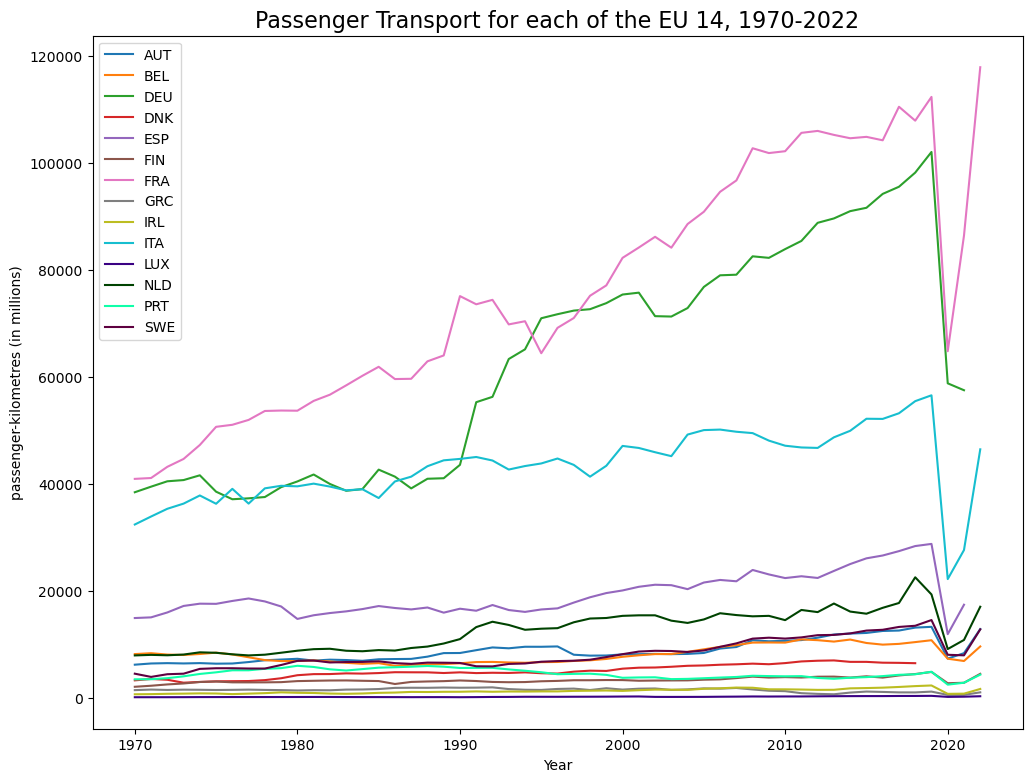

In [34]:
df3_EU14_pivot = df3_EU14.pivot(index='year', columns='LOCATION', values='Value')

custom_palette2 = sns.color_palette(cc.glasbey_category10, n_colors=len(df3_EU14_pivot.columns))

plt.figure(figsize=(12,9))

for i, LOCATION in enumerate(df3_EU14_pivot.columns):
    sns.lineplot(x=df3_EU14_pivot.index, y=df3_EU14_pivot[LOCATION], label=LOCATION, color=custom_palette2[i], legend='brief')
        
plt.xlabel('Year')
plt.ylabel('passenger-kilometres (in millions)')
plt.title('Passenger Transport for each of the EU 14, 1970-2022', fontsize=16)

plt.show()

This graph is hard to read, as the Big 4 in the EU (France, Germany, Italy, Spain) have such high values. So, I'll do the graph again, excluding these big 4:

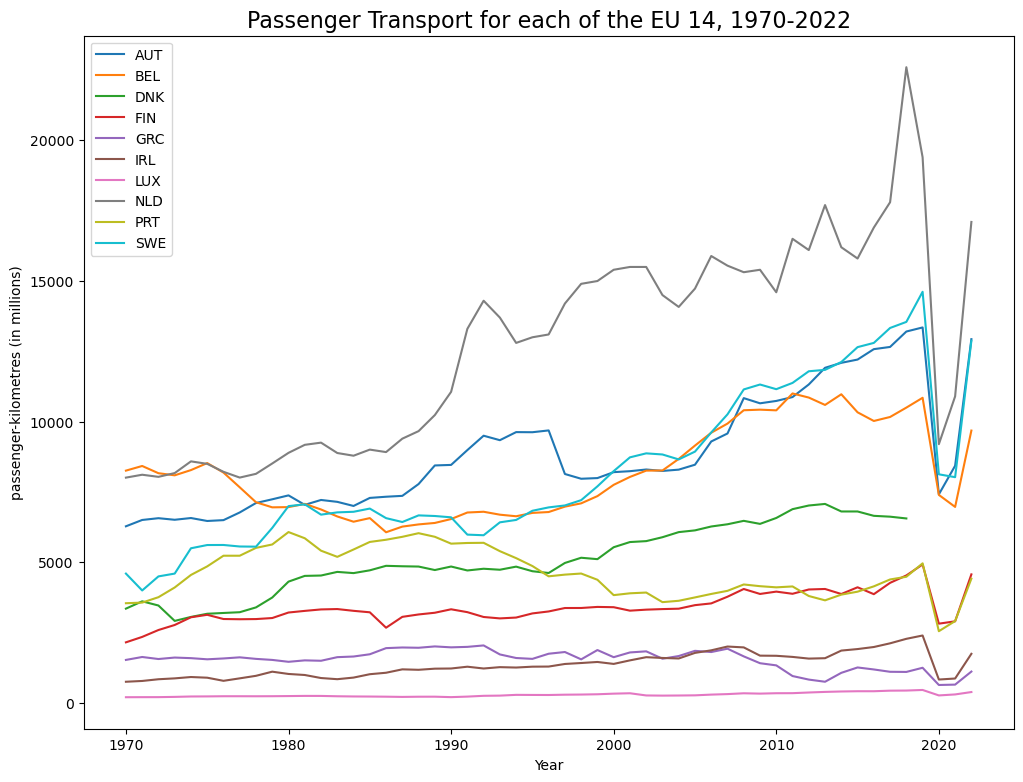

In [42]:
df3_EU14_revised = df3_EU14[~df3_EU14['LOCATION'].isin(['FRA', 'DEU', 'ITA', 'ESP'])].reset_index(drop=True)

df3_EU14_revised_pivot = df3_EU14_revised.pivot(index='year', columns='LOCATION', values='Value')

custom_palette2 = sns.color_palette(cc.glasbey_category10, n_colors=len(df3_EU14_revised_pivot.columns))

plt.figure(figsize=(12,9))

for i, LOCATION in enumerate(df3_EU14_revised_pivot.columns):
    sns.lineplot(x=df3_EU14_revised_pivot.index, y=df3_EU14_revised_pivot[LOCATION], label=LOCATION, color=custom_palette2[i], legend='brief')
        
plt.xlabel('Year')
plt.ylabel('passenger-kilometres (in millions)')
plt.title('Passenger Transport for each of the EU 14, 1970-2022', fontsize=16)

plt.show()

It is now much easier to compare Ireland to other EU MS.

Overall, each MS seems to have followed similar trends to what was observed in the primary dataset: steady growth, with a drop in 2020 resulting from the pandemic.

Ireland unfortunately still ranks low among these, so it'll be interesting to see 

Looking alphabetically:
* Austria (AUT):

<summary style="color:blue;">
    
# 4. Comparison of Rail Transport in Ireland to another EU country: Denmark
    
</summary>

I decided to look at Denmark, as it is has a similar population to Ireland (Denmark 5.857 million as of 2021, and Ireland 5.033 million as of 2021). However, Ireland is approx. 1.6 times bigger than Denmark. Thus, it will be interesting to compare the rail data.